# DATASET

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Acknowledgements
Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Inspiration
Automated methods to detect and classify human diseases from medical images.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
import os
import random
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D,Dense,Flatten,Dropout,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# ! pip install -q scikit-plot
# !pip install h5py
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
total_images_train_normal = os.listdir('/content/ChestXRay2017preprocess/train/NORMAL')
total_images_train_pneumonia = os.listdir('/content/ChestXRay2017preprocess/train/PNEUMONIA')

In [0]:
image_height = 300
image_width = 300
batch_size = 16
no_of_epochs  = 20

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split= 0.10)

test_datagen = ImageDataGenerator(rescale=1./255,
                                  )

In [0]:
training_set = train_datagen.flow_from_directory('/content/ChestXRay2017preprocess/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary',
                                                 subset='training')

val_set = train_datagen.flow_from_directory('/content/ChestXRay2017preprocess/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary',
                                                 subset='validation')

test_set = test_datagen.flow_from_directory('/content/ChestXRay2017preprocess/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

Found 5251 images belonging to 2 classes.
Found 583 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


# TRAINING OF InceptionResNetV2 Using Transfer Learning

In [0]:
# keras.applications.densenet.DenseNet121

prev_model=keras.applications.inception_resnet_v2.InceptionResNetV2(weights=None ,input_shape=(image_height,image_width,3))


fc = Dense(256,activation='relu')(prev_model.output)
drop = Dropout(0.4)(fc)
fc2 = Dense(1,activation='sigmoid')(drop)

model = Model(inputs=prev_model.input, outputs=fc2)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
 reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

mc = ModelCheckpoint('best_model-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                     mode='auto', save_best_only=True)
callbacks = [reduce_learning_rate, mc]

In [0]:
opt=keras.optimizers.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=training_set,
                              epochs=50,
                              validation_data=val_set,
                              callbacks=callbacks,
                              shuffle=True)

Epoch 1/50
329/329 [==============================] - 373s 1s/step - loss: 0.4038 - accuracy: 0.8216 - val_loss: 0.7955 - val_accuracy: 0.5746
Epoch 2/50
329/329 [==============================] - 289s 878ms/step - loss: 0.2979 - accuracy: 0.8772 - val_loss: 1.7589 - val_accuracy: 0.2693
Epoch 3/50
329/329 [==============================] - 289s 880ms/step - loss: 0.2765 - accuracy: 0.8928 - val_loss: 0.0447 - val_accuracy: 0.8611
Epoch 4/50
329/329 [==============================] - 288s 877ms/step - loss: 0.2597 - accuracy: 0.9000 - val_loss: 0.0931 - val_accuracy: 0.8679
Epoch 5/50
329/329 [==============================] - 289s 878ms/step - loss: 0.2500 - accuracy: 0.9074 - val_loss: 0.9726 - val_accuracy: 0.7307

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
329/329 [==============================] - 289s 878ms/step - loss: 0.2311 - accuracy: 0.9191 - val_loss: 0.1492 - val_accuracy: 0.9005
Epoch 7/50
329/329 [=========================

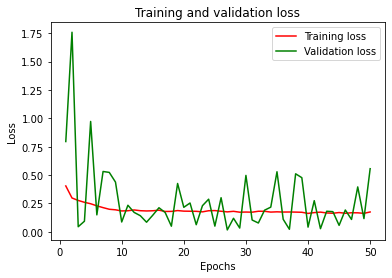

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

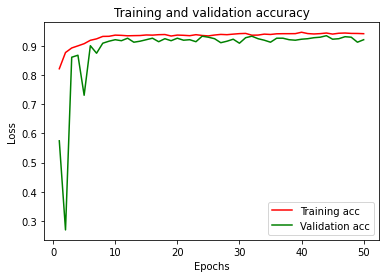

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.load_weights('best_model-27-0.02.hdf5')                  #using load_weights function 
score=model.evaluate(training_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

329/329 [==============================] - 168s 510ms/step
Test accuracy is 94.9724%


In [0]:
model.load_weights('best_model-27-0.02.hdf5')                  #using load_weights function 
score=model.evaluate(test_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

2/2 [==============================] - 2s 992ms/step
Test accuracy is 95.4545%


In [0]:
model.load_weights('best_model-27-0.02.hdf5')                  #using load_weights function 
score=model.evaluate(val_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

37/37 [==============================] - 19s 501ms/step
Test accuracy is 92.2813%


# OUR PROPOSED CNN MODEL 

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
reg=None
num_filters=32
ac='relu'
adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0.3
img_rows, img_cols,channels =32,32,3 

model = Sequential()


model.add(Convolution2D(32, (3, 3), input_shape=(300,300,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Convolution2D(32, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))

model.add(Convolution2D(2*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Convolution2D(2*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))


model.add(Convolution2D(4*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Convolution2D(4*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))


model.add(Convolution2D(6*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Convolution2D(6*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))

model.add(Convolution2D(8*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Convolution2D(8*32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(units=1,activation='sigmoid'))
model.summary()


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 300, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 300, 300, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 64)     

In [0]:
 reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

mc = ModelCheckpoint('best_model-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                     mode='auto', save_best_only=True)
callbacks = [reduce_learning_rate, mc]


In [0]:
opt=keras.optimizers.Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(generator=training_set,
                              # steps_per_epoch=int(len(training_set)//batch_size),
                              # steps_per_epoch=3735//batch_size,
                              epochs=50,
                              validation_data=val_set,
                              # validation_steps=int(len(val_set)//batch_size),
                              # validation_steps=2099//batch_size,
                              callbacks=callbacks,
                              shuffle=True)

Epoch 1/50
329/329 [==============================] - 193s 588ms/step - loss: 0.1869 - accuracy: 0.9290 - val_loss: 0.0085 - val_accuracy: 0.8988
Epoch 2/50
329/329 [==============================] - 187s 570ms/step - loss: 0.1889 - accuracy: 0.9337 - val_loss: 0.0971 - val_accuracy: 0.9228
Epoch 3/50
329/329 [==============================] - 187s 569ms/step - loss: 0.1777 - accuracy: 0.9343 - val_loss: 0.8158 - val_accuracy: 0.9194

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
329/329 [==============================] - 187s 570ms/step - loss: 0.1532 - accuracy: 0.9467 - val_loss: 0.0298 - val_accuracy: 0.9383
Epoch 5/50
329/329 [==============================] - 187s 570ms/step - loss: 0.1510 - accuracy: 0.9467 - val_loss: 0.0106 - val_accuracy: 0.9262
Epoch 6/50
329/329 [==============================] - 188s 570ms/step - loss: 0.1514 - accuracy: 0.9482 - val_loss: 0.0198 - val_accuracy: 0.9417

Epoch 00006: ReduceLROnPlateau reducing l

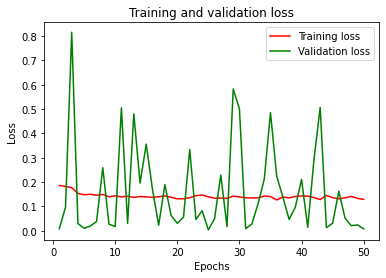

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

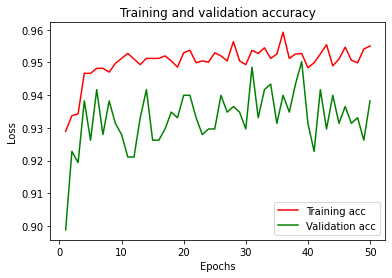

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
model.load_weights('best_model-25-0.00.hdf5')                  #using load_weights function 
score=model.evaluate(test_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

2/2 [==============================] - 0s 208ms/step
Test accuracy is 100.0000%


In [0]:
model.load_weights('best_model-25-0.00.hdf5')                  #using load_weights function 
score=model.evaluate(val_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

37/37 [==============================] - 16s 428ms/step
Test accuracy is 94.3396%


In [0]:
model.load_weights('best_model-25-0.00.hdf5')                  #using load_weights function 
score=model.evaluate(training_set,verbose=1)               #evaluates the model
accuracy=100*score[1]                                       
print('Test accuracy is %.4f%%' % accuracy)                 #returns the accuracy of the model 

329/329 [==============================] - 143s 433ms/step
Test accuracy is 96.4769%


# Comparison Study

InceptionResNetV2	Validation accuracy 92.28%	 Training accuracy 94.97%

Proposed CNN Model	Validation accuracy 94.33%	 Training accuracy 96.47%


The Proposed CNN model performs well as compared to InceptionResNetV2 with a smaller number of parameters and requires less amount of computational resources as well as less time to train the model.